# [ATM 623: Climate Modeling](../index.ipynb)
[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany
# Lecture 13: Heat transport

## Contents

1. [First section title](#section1)

____________
<a id='section1'></a>

## 1. Spatial patterns of insolation and surface temperature
____________

Some text.

In [1]:
#  load surface temperature data.
#  See that annual mean it is highly correlated 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import climlab
from climlab import constants as const

In [3]:
#  Calculate daily average insolation as function of latitude and time of year
lat = np.linspace( -90., 90., 500. )
days = np.linspace(0, const.days_per_year, 365. )
Q = climlab.solar.insolation.daily_insolation( lat, days )

In [4]:
#  daily surface temperature from  NCEP reanalysis
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_temp = nc.Dataset( ncep_url + "surface_gauss/skt.sfc.day.1981-2010.ltm.nc" )
lat_ncep = ncep_temp.variables['lat'][:]
time_ncep = ncep_temp.variables['time'][:]
ncep_temp_zon = np.mean(ncep_temp.variables['skt'][:], axis=2)

/Users/Brian/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/Brian/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


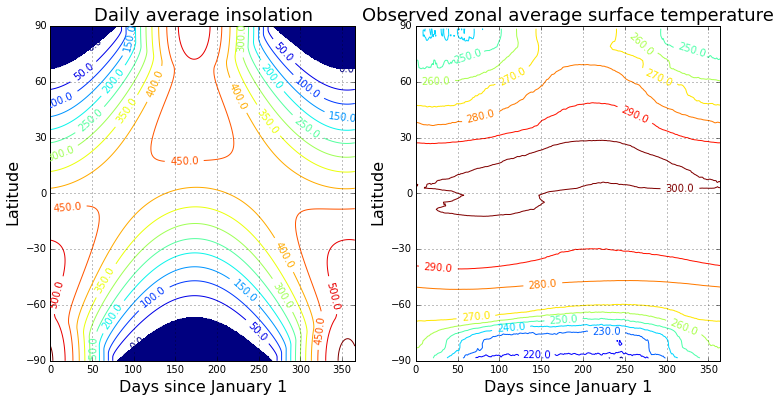

In [5]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
CS = ax1.contour( days, lat, Q , levels = np.arange(0., 600., 50.) )
ax1.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax1.set_title('Daily average insolation', fontsize=18 )
ax1.contourf ( days, lat, Q, levels=[0., 0.] )

ax2 = fig.add_subplot(122)
CS = ax2.contour( (time_ncep - time_ncep[0])/const.hours_per_day, lat_ncep, 
                 ncep_temp_zon.T, levels=np.arange(210., 310., 10. ) )
ax2.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax2.set_title('Observed zonal average surface temperature', fontsize=18 )

for ax in [ax1,ax2]:
    ax.set_xlabel('Days since January 1', fontsize=16 )
    ax.set_ylabel('Latitude', fontsize=16 )
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.grid()

____________
<a id='section2'></a>

## 2. Calculating Radiative-Convective Equilibrium as a function of latitude
____________

Let's use the `climlab.BandRCModel` to calculate a radiative-convective equilibrium state for every latitude band.

In [6]:
#  Create a model with both latitude and pressure dimensions
model = climlab.BandRCModel(num_lev=30, num_lat=90)
print model

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  q: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [7]:
model.compute_diagnostics()

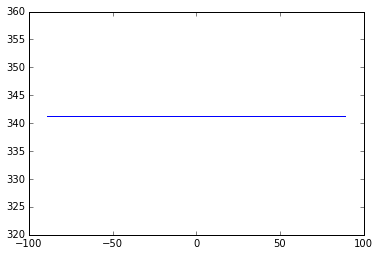

In [8]:
plt.plot(model.lat, model.diagnostics['insolation'])

In [9]:
#  Change the insolation process to use actual daily insolation as a function of latitude and time of year
model = climlab.BandRCModel(num_lev=30, num_lat=90, adj_lapse_rate=6.)
insolation = climlab.radiation.insolation.DailyInsolation(domains=model.Ts.domain)
model.add_subprocess('insolation', insolation)
print model

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  q: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [10]:
#  model is initialized on Jan. 1

#  integrate forward just under 1/4 year... should get about to the NH spring equinox
model.integrate_days(31+28+22)
Q_spring = model.diagnostics['insolation']
#  Then forward to NH summer solstice
model.integrate_days(31+30+31)
Q_summer = model.diagnostics['insolation']
#  and on to autumnal equinox
model.integrate_days(30+31+33)
Q_fall = model.diagnostics['insolation']
#  and finally to NH winter solstice
model.integrate_days(30+31+30)
Q_winter = model.diagnostics['insolation']

Integrating for 81 steps, 81.0 days, or 0.221770649722 years.
Total elapsed time is 0.221770649722 years.
Integrating for 91 steps, 92.0 days, or 0.251887651536 years.
Total elapsed time is 0.470920392003 years.
Integrating for 94 steps, 94.0 days, or 0.257363470048 years.
Total elapsed time is 0.728283862051 years.
Integrating for 91 steps, 91.0 days, or 0.249149742281 years.
Total elapsed time is 0.977433604332 years.


/Users/Brian/climlab/climlab/model/column.py:129: RuntimeWarning: divide by zero encountered in divide
  SW.flux_from_space)


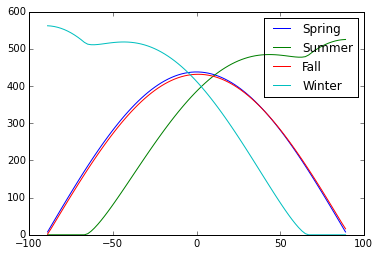

In [11]:
plt.plot(model.lat, Q_spring, label='Spring')
plt.plot(model.lat, Q_summer, label='Summer')
plt.plot(model.lat, Q_fall, label='Fall')
plt.plot(model.lat, Q_winter, label='Winter')
plt.legend()

In [12]:
#  We want to integrate this model out to quasi-equilibrium (steady annual cycle)

#  But first add some ozone

In [13]:
#  Put in some ozone

datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

topo = nc.Dataset( datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr )
ozone = nc.Dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc' + endstr )

#  Dimensions of the ozone file
lat = ozone.variables['lat'][:]
lon = ozone.variables['lon'][:]
lev = ozone.variables['lev'][:]

# Taking annual, zonal average of the ozone data
O3_zon = np.mean( ozone.variables['O3'],axis=(0,3) )

In [14]:
#  make a new model on the same grid as the ozone data!
model = climlab.BandRCModel(lat=lat, lev=lev)
insolation = climlab.radiation.insolation.DailyInsolation(domains=model.Ts.domain)
model.add_subprocess('insolation', insolation)

In [15]:
#  Set the ozone mixing ratio
#   IMPORTANT: we need to flip the ozone array around because the vertical coordinate runs the wrong way
#   (first element is top of atmosphere, whereas our model expects the first element to be just above the surface)
O3_trans = np.transpose(O3_zon)
O3_flipped = np.fliplr(O3_trans)

model.absorber_vmr['O3'] = O3_flipped

In [16]:
model.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


In [17]:
model.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 2.99801063513 years.


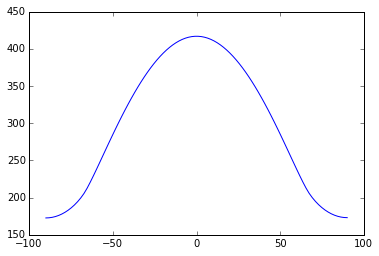

In [18]:
plt.plot(model.lat, model.timeave['insolation'])

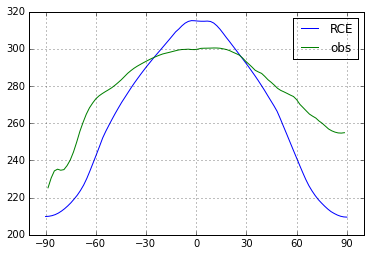

In [19]:
# Plot annual mean surface temperature in the model,
#   compare to observed annual mean surface temperatures
plt.plot(model.lat, model.timeave['Ts'], label='RCE')
plt.plot(lat_ncep, np.mean(ncep_temp_zon, axis=0), label='obs')
plt.xticks(range(-90,100,30))
plt.grid()
plt.legend()

In [20]:
#  Observed air temperature from NCEP reanalysis

ncep_air = nc.Dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc" )
level_ncep_air = ncep_air.variables['level'][:]
lat_ncep_air = ncep_air.variables['lat'][:]
Tzon = np.mean(ncep_air.variables['air'],axis=(0,3))

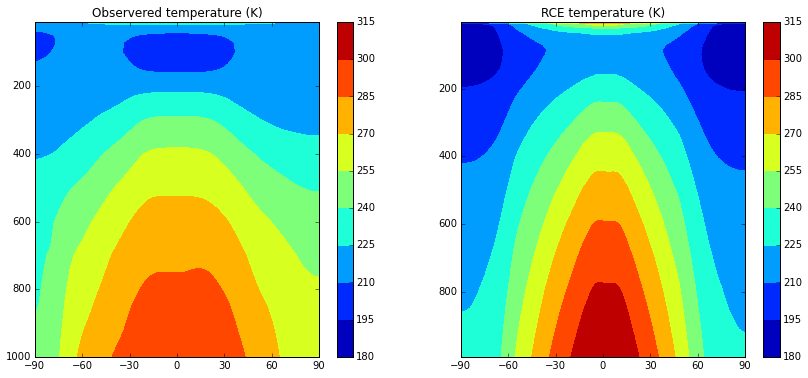

In [21]:
#  Compare temperature profiles in RCE and observations
contours = np.arange(180., 325., 15.)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
cax1 = ax1.contourf(lat_ncep_air, level_ncep_air, Tzon+const.tempCtoK, levels=contours)
fig.colorbar(cax1)
ax1.set_title('Observered temperature (K)')

ax2 = fig.add_subplot(1,2,2)
field = model.timeave['Tatm'].transpose()
cax2 = ax2.contourf(model.lat, model.lev, field, levels=contours)
fig.colorbar(cax2)
ax2.set_title('RCE temperature (K)')

for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])

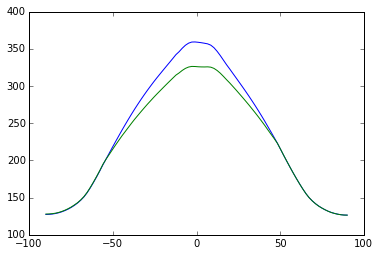

In [22]:
plt.plot(model.lat, model.timeave['ASR'])
plt.plot(model.lat, model.timeave['OLR'])

In [23]:
model.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.99734751351 years.


In [24]:
#  There's a bug..........

____________
<a id='section3'></a>

## 3. Observed and modeled TOA radiation budget
____________


In [25]:
# Get TOA radiative flux data from NCEP reanalysis

# downwelling SW
dswrf = nc.Dataset(ncep_url + '/other_gauss/dswrf.ntat.mon.1981-2010.ltm.nc')
#  upwelling SW
uswrf = nc.Dataset(ncep_url + '/other_gauss/uswrf.ntat.mon.1981-2010.ltm.nc')
#  upwelling LW
ulwrf = nc.Dataset(ncep_url + '/other_gauss/ulwrf.ntat.mon.1981-2010.ltm.nc')

In [26]:
ASR = dswrf.variables['dswrf'][:] - uswrf.variables['uswrf'][:]
OLR = ulwrf.variables['ulwrf'][:]

In [27]:
ASRzon = np.mean(ASR, axis=(0,2))
OLRzon = np.mean(OLR, axis=(0,2))

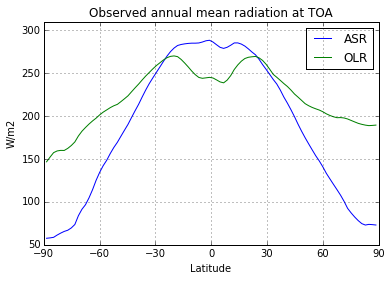

In [28]:
ticks = [-90, -60, -30, 0, 30, 60, 90]

fig, ax = plt.subplots()
ax.plot(lat_ncep, ASRzon, label='ASR')
ax.plot(lat_ncep, OLRzon, label='OLR')
ax.set_ylabel('W/m2')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90)
ax.set_ylim(50,310)
ax.set_xticks(ticks);
ax.legend()
ax.set_title('Observed annual mean radiation at TOA')
ax.grid()

In [29]:
#  same thing from CESM control simulation
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"
atm_control = nc.Dataset( datapath + 'som_control/som_control.cam.h0.clim.nc' + endstr )

In [30]:
lat_cesm = atm_control.variables['lat'][:]
ASR_cesm = atm_control.variables['FSNT'][:]
OLR_cesm = atm_control.variables['FLNT'][:]

In [31]:
ASR_cesm_zon = np.mean(ASR_cesm, axis=(0,2))
OLR_cesm_zon = np.mean(OLR_cesm, axis=(0,2))

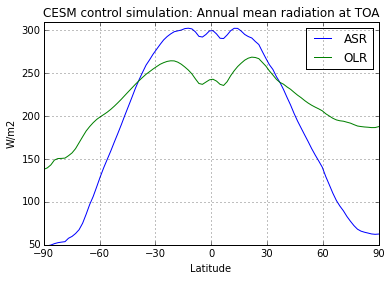

In [32]:
fig, ax = plt.subplots()
ax.plot(lat_cesm, ASR_cesm_zon, label='ASR')
ax.plot(lat_cesm, OLR_cesm_zon, label='OLR')
ax.set_ylabel('W/m2')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90)
ax.set_ylim(50,310)
ax.set_xticks(ticks);
ax.legend()
ax.set_title('CESM control simulation: Annual mean radiation at TOA')
ax.grid()

____________
<a id='section4'></a>

## 4. Observed and modeled poleward heat transport
____________



In [33]:
from IPython.display import Image
Image(url='http://www.cgd.ucar.edu/cas/Topics/PolewardTransp.png', width=800)

> The ERBE period zonal mean annual cycle of the meridional energy transport in PW by (a) the atmosphere and ocean from ERBE products (b) the atmosphere based on NRA; and (c) by the ocean as implied by ERBE + NRA and GODAS. Stippling and hatching in (a)â€“(c) represent regions and times of year in which the standard deviation of the monthly mean values among estimates, some of which include the CERES period (see text), exceeds 0.5 and 1.0 PW, respectively. (d) The median annual mean transport by latitude for the total (gray), atmosphere (red), and ocean (blue) accompanied with the associated 2 range (shaded). - From Fasullo and Trenberth, 2008b.

Source: http://www.cgd.ucar.edu/cas/Topics/energybudgets.html

In [36]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )


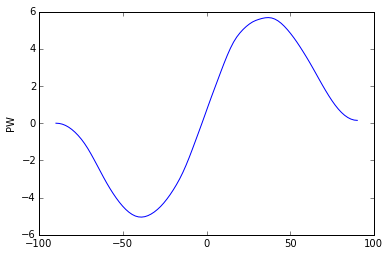

In [40]:
#  We can calculate the total (atm + ocean) northward heat transport from CESM output
plt.plot(lat_cesm, inferred_heat_transport(ASR_cesm_zon - OLR_cesm_zon, lat_cesm))
plt.ylabel('PW')

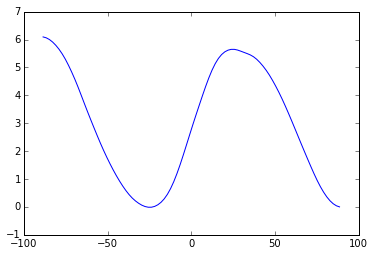

In [38]:
#  This illustrates the difficulty with calculating heat transport from unbalanced data
plt.plot(lat_ncep, inferred_heat_transport(ASRzon - OLRzon, lat_ncep))

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php), offered in Spring 2015.
____________

____________
## Version information
____________


In [34]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, climlab

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 2.7.9 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 3.0.0
OS Darwin 13.4.0 x86_64 i386 64bit
numpy 1.9.2
climlab 0.2.4
Tue Mar 31 14:23:45 2015 EDT